In [ ]:
!pip install -q transformers datasets evaluate optuna scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.1 MB/s eta 0:00:00


In [ ]:
!pip install evaluate
!pip install optuna

In [ ]:
import torch
print("GPU available:", torch.cuda.is_available())


GPU available: True


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = 'filepath'
df = pd.read_csv(file_path)
df.head()


,ID,prompt,response,rating,set,word_count
0,93796,gross food,The drink was worse than poison.,-0.274770,training,6
1,94049,boring class,That class was as dull as dishwater,-1.363663,training,7
2,3153,bad movie,watching that movie was like torture,-1.213888,training,6
3,90939,gross food,That drink was pure sludge.,-0.819217,training,5
4,2184,gross food,Eating the day old corn dog was like brushing ...,0.598379,training,15


In [ ]:
import evaluate
import numpy as np
import pandas as pd
import torch
import os
import optuna

from datasets import Dataset, DatasetDict
from sklearn.preprocessing import StandardScaler
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, GPT2Tokenizer,
    TrainingArguments, Trainer
)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [ ]:
model_name = "gpt2"
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=1)
tokenizer = GPT2Tokenizer.from_pretrained(model_name, padding_side='right')
tokenizer.pad_token = tokenizer.eos_token

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

def compute_metrics(eval_preds):
    predictions, labels = eval_preds
    mse = mse_metric.compute(predictions=predictions, references=labels)['mse']
    rmse = np.sqrt(mse)
    return {"rmse": rmse}


In [ ]:
direc = os.getcwd()
d = pd.read_csv(file_path)

scaler = StandardScaler()
d['label'] = d['rating']
d['inputs'] = "A novel metaphor for " + d['prompt'] + " is: " + d['response']
d['text'] = d['inputs']
d_input = d[['text', 'label', 'set']]


In [ ]:
dataset = Dataset.from_pandas(d_input)

dataset_split = DatasetDict({
    'train': dataset.filter(lambda example: example['set'] == 'training'),
    'validation': dataset.filter(lambda example: example['set'] == 'validation'),
    'test': dataset.filter(lambda example: example['set'] == 'test'),
    'heldout': dataset.filter(lambda example: example['set'] == 'heldout')
}).remove_columns('set')

tokenized_datasets = dataset_split.map(tokenize_function, batched=True)


In [ ]:
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2.47e-5,
    num_train_epochs=139,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=True,
    disable_tqdm=False,
    logging_steps=100,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    #compute_metrics=compute_metrics,
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


In [ ]:
trainer.train()

In [ ]:
prediction = trainer.predict(tokenized_datasets['test'])
test_df = pd.DataFrame({
    'text': tokenized_datasets['test']['text'],
    'label': tokenized_datasets['test']['label'],
    'prediction': np.squeeze(prediction.predictions)
})
test_df.to_csv("/content/test_predictions.csv", index=False)


In [ ]:
import pandas as pd
from google.colab import files
df_test = pd.read_csv("test_predictions.csv")
df_test.columns


Index(['text', 'label', 'prediction'], dtype='object')

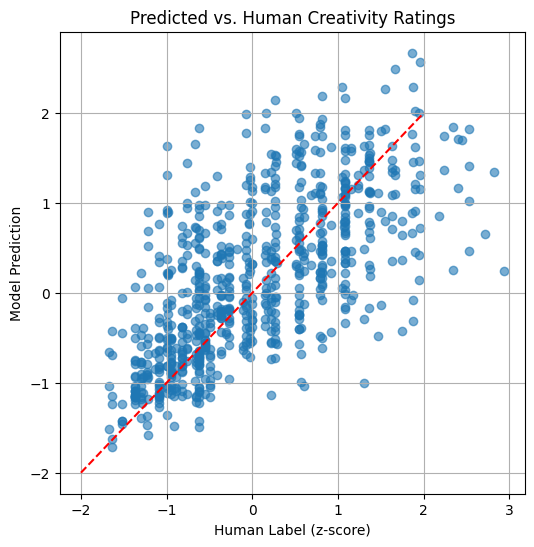

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(df_test['label'], df_test['prediction'], alpha=0.6)
plt.plot([-2, 2], [-2, 2], 'r--')
plt.xlabel("Human Label (z-score)")
plt.ylabel("Model Prediction")
plt.title("Predicted vs. Human Creativity Ratings")
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import pearsonr
r, _ = pearsonr(df_test['label'], df_test['prediction'])
print(f"Pearson correlation: {r:.2f}")


Pearson correlation: 0.67


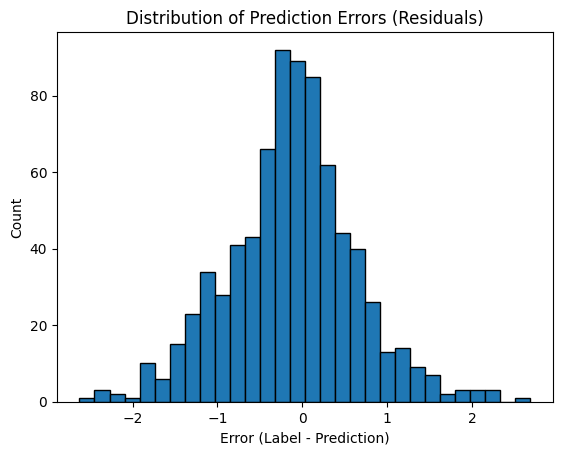

In [ ]:
import matplotlib.pyplot as plt

residuals = df_test['label'] - df_test['prediction']
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error (Label - Prediction)")
plt.ylabel("Count")
plt.show()


In [ ]:
model.push_to_hub("name", token = "token")
tokenizer.push_to_hub("name", token = "token")

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch



model_path = "modelname"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model.eval()


df = pd.read_csv("/content/base_mistral_metaphors.csv", encoding="ISO-8859-1")




inputs = tokenizer(list(df['text']), return_tensors="pt", padding=True, truncation=True)


with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits.squeeze().cpu().numpy()


df['predicted_creativity'] = predictions


df.to_csv("scored_metaphors.csv", index=False)
df.head()


,text,predicted_creativity
0,A novel metaphor for a drone strike is: a deat...,-0.529077
1,A novel metaphor for a drone strike is: 9/11 e...,0.299654
2,A novel metaphor for a drone strike is: 16 fir...,-0.215816
3,A novel metaphor for a drone strike is: 3.5 bi...,0.329455
4,A novel metaphor for a bullet is: 60g of steel...,0.946450


In [ ]:
df['predicted_creativity'].describe()


,predicted_creativity
count,42.000000
mean,0.389767
std,0.796061
min,-0.894015
25%,-0.162261
50%,0.307554
75%,0.719567
max,2.122112


In [ ]:
top = df.sort_values(by="predicted_creativity", ascending=False).head(10)
bottom = df.sort_values(by="predicted_creativity", ascending=True).head(10)


In [ ]:
top.head()

,text,predicted_creativity
13,A novel metaphor for a tear gas canister is: 2...,2.122112
19,A novel metaphor for a last name is: a fingerp...,2.078955
20,A novel metaphor for a last name is: 1 digits ...,2.068791
38,A novel metaphor for a dollar is: 1 rupee in t...,1.741216
15,A novel metaphor for a tear gas canister is: 3...,1.611491


In [ ]:
top.to_csv("top_metaphors.csv", index=False)
bottom.to_csv("bottom_metaphors.csv", index=False)

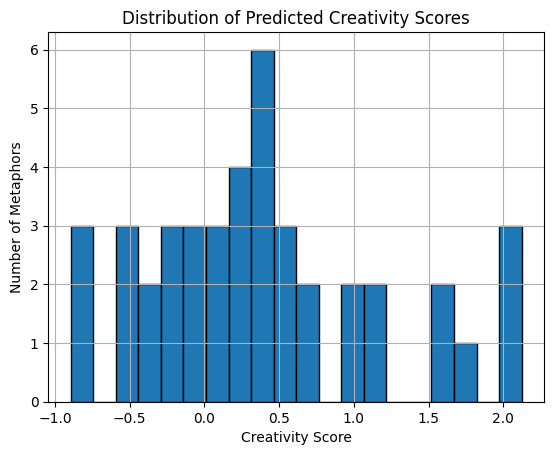

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df['predicted_creativity'], bins=20, edgecolor='black')
plt.title("Distribution of Predicted Creativity Scores")
plt.xlabel("Creativity Score")
plt.ylabel("Number of Metaphors")
plt.grid(True)
plt.show()


In [ ]:
df['topic'] = df['text'].str.extract(r'for a (.+?) is', expand=False)


In [ ]:
df.groupby("topic")["predicted_creativity"].mean().sort_values(ascending=False)


,predicted_creativity
topic,
last name,1.411837
dollar,0.842022
tear gas canister,0.823720
missile,0.690710
jail cell,0.341025
bullet,0.320625
drone strike,-0.028946
riot,-0.078657
cop's badge,-0.091473


<Axes: ylabel='topic'>

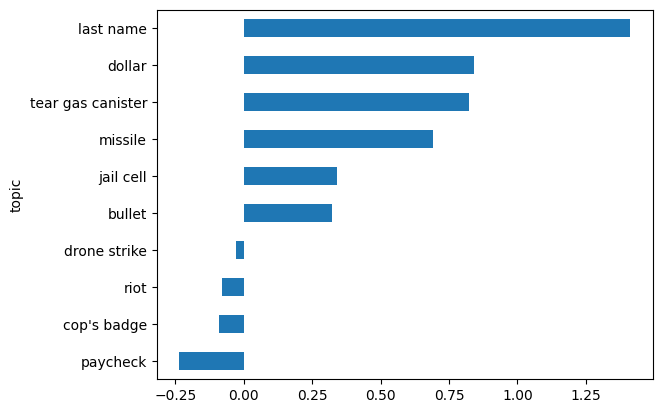

In [ ]:
df.groupby("topic")["predicted_creativity"].mean().sort_values().plot(kind="barh")
